In [1]:
import os
os.chdir('/Users/talespadilha/Documents/Projects/fx_vol')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import general_functions as gf
from arch import arch_model
from nominal_fx_data import nominal_import
from garch_selection import garch_volatility


def est_ols_ar(series, factors):
    y = series[~series.isna()]
    factors = factors[~series.isna()]
    x = pd.concat([factors.rename('f'), y.shift(1).rename('lag')], axis=1)
    x = sm.add_constant(x)
    mod = sm.OLS(y[1:], x[1:])
    res = mod.fit()

    return res


def est_ols(series, factors):
    x = sm.add_constant(factors.rename('f'))
    y = series[~series.isna()]
    x = x[~series.isna()]
    mod = sm.OLS(y, x)
    res = mod.fit()

    return res


def corr_list(df):
    l=[]
    for i in range(len(df)):
        for j in range(i):
            if i>j:
                l.append(df.iloc[i,j])
    ls = pd.Series(l)
                
    return ls


def garch11(series):
    mod = arch_model(series, p=1, o=0, q=1)
    vol = mod.fit(disp="off").conditional_volatility
    
    return vol


def calc_rv(df, freq='MS'):
    squared=df**2
    final_df = squared.resample(freq).mean()
    
    return final_df
                

path = '/Users/talespadilha/Documents/Oxford/Research/Real Exchange Rate Volatility/Data Files/'

In [2]:
fx = pd.read_csv('fx.csv', header=[0], index_col = [0])

In [3]:
# Getting returns and getting rid of extreme values
r_fx = (fx.pct_change()*100).dropna(how='all')
r_fx[r_fx>10] = 10
r_fx[r_fx<-10] = -10

EMS, DMS = gf.markets_set(r_fx, path)

# Geopolitical Risk and The PPP Puzzle


### Explaining FX Volatility Using a GEVOL


Susana Campos-Martins and Tales Padilha

We estimated the following CS-ARDL panel framework:

$$ \sigma^{2R}_{i,t} = \eta_i + \alpha_i \sigma^{2R}_{i,t-1} + \beta_{i,1} \sigma^{EP}_{i,t} + \beta_{i,2} \sigma^{2E}_{i,t} + \beta_{i,3} \sigma^{2P}_{i,t} + \gamma_i \bar{\sigma}^{2R}_{t-1} + \omega_i \bar{\sigma}^{2R}_{t} + v_{i,t} $$

We idendified that:
* Real exchange rate volatility is a lot more presistent in DMs than in EMs;
* Nominal exchange rate volatility is the only significant component in EMs and DMs (at all levels - cov at 10%);
* By far, the most significant "exogenous" driver of real exchange rate volatility is the group mean;
* This extremely important for EMs
* And this mean effect is much more significant when considering EMs and DMs separately

# Daily Nominal FX Returns

Following Engle & Martins (WP) we estimate the following one factor model to control for first moments:

$$ r_{i,t} = \alpha_i + \beta_i f_t + e_{i,t} $$

where $f_t$ is just the mean return of the exchange rates for day $t$. 

We do this in two settings:

* Analysing one factor $f_t$ and considering all 29 countries as part of the same group
* One $f^{EM}_t$ factor for EMs and $f^{DM}_t$ factor for DMs and proceeding separately for EMs and DMs

# Looking at Daily Returns

In [34]:
# Selecting the set of countries
countries = EMS+DMS

# Calculating the mean factor
f = r_fx[countries].mean(axis=1)

# Estimating the mean factor model
e={}
b={}
for country in countries:
    res = est_ols_ar(r_fx[country], f)
    #res = est_ols(r_fx[country], f)
    e[country] = res.resid
    b[country] = res.params
e_hat = pd.concat(e, axis=1)
betas = pd.concat(b, axis=1)

# Estimating volatility
e_hat10 = e_hat*10
v = {}
m = {}
for country in e_hat10:
    v[country] = garch11(e_hat10[country].dropna())  
vol = pd.concat(v, axis=1)/10

# Standard residuals
std_e = e_hat/vol
std_e2 = std_e**2

In [39]:
print(f"Returns mean corr:{corr_list(r_fx[countries].corr()).mean()}")
print(f"Residuals mean corr: {corr_list(e_hat.corr()).mean()}")

Returns mean corr:0.29950985254566176
Residuals mean corr: -0.020766336409844658


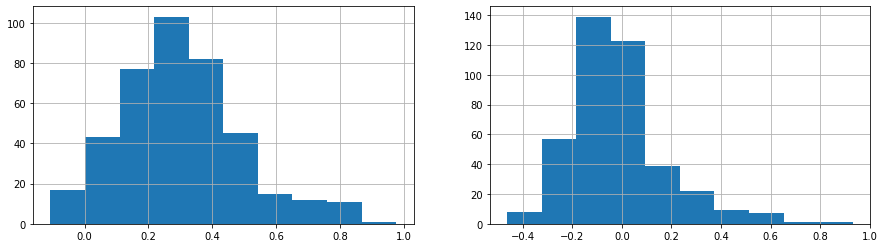

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
corr_list(r_fx[countries].corr()).hist(ax=axes[0])
corr_list(e_hat.corr()).hist(ax=axes[1])

In [48]:
print(f"Std residuals mean corr:{corr_list(std_e.corr()).mean()}")
print(f"Squared std residuals mean corr: {corr_list(std_e2.corr()).mean()}")

Std residuals mean corr:-0.017287720399724735
Squared std residuals mean corr: 0.071298782163384


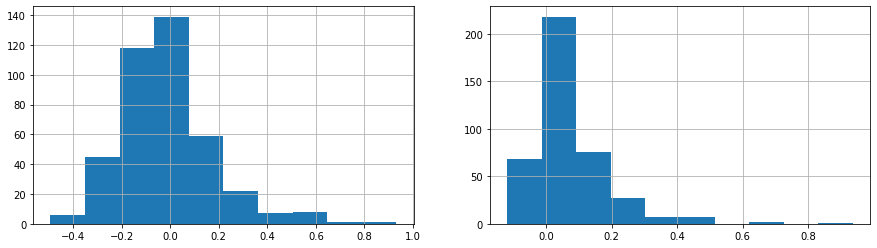

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
corr_list(std_e.corr()).hist(ax=axes[0])
corr_list(std_e2.corr()).hist(ax=axes[1])

In [ ]:
path = '/Users/talespadilha/Documents/Oxford/Research/Real Exchange Rate Volatility/Data Files/'
# Importing GEOVOL data
x_daily = pd.read_csv(path+'geovols/daily_all.csv', index_col=0)
x_daily.index = pd.to_datetime(x_daily.index, format='%d/%m/%Y')
s = pd.read_csv(path+'geovols/s_all.csv', index_col=0)
x_monthly = x_daily.resample('MS').mean()

# Lower Frequency - Monthly "Realized"

In [104]:
print(f"Std residuals mean corr:{corr_list(std_e.resample('MS').mean().corr()).mean()}")
print(f"Squared residuals mean corr: {corr_list(calc_rv(std_e).corr()).mean()}")

Std residuals mean corr:-0.01932434517462843
Squared residuals mean corr: 0.18803533914148615


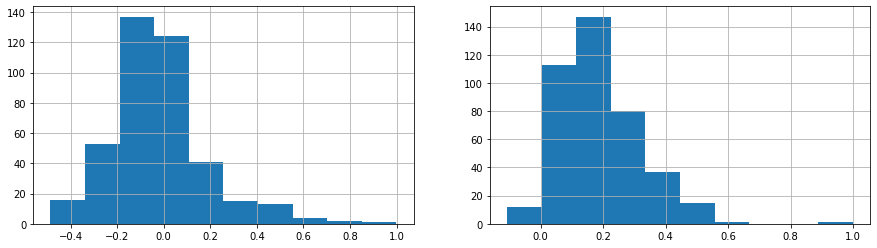

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
corr_list(std_e.resample('MS').mean().corr()).hist(ax=axes[0])
corr_list(calc_rv(std_e).corr()).hist(ax=axes[1])

# Testing for GEOVOL

In [10]:
psi = std_e2 - 1
N = psi.shape[1]
T = psi.shape[0]
a=[]
for i in range(N):
    for j in range(i):
        if i>j:
            for t in range(T):
                a.append(psi.iloc[t,i]*psi.iloc[t,j])
a_series = pd.Series(a)
b=[]
for i in range(N):
    for t in range(T):
        b.append(psi.iloc[t,i]**2)
b_series = pd.Series(b)
xi = np.sqrt((N*T)/((N-1)/2)) * (a_series.sum()/b_series.sum())
print(xi)

20.78188616921844


# Way forward:

It seems reasonable to focus on monthly realized volatility of standarized residuals. What do you think?

If this remaining correlation comes from GEOVOL we would expect $\frac{RV^{std_e}_m}{g(s_i\bar{x}_m)}$ to be uncorrelated.

Where $\bar{x}_m$ is the monthly mean GEOVOL